# Generating Synthetic Datasets

This notebook specifies the data generation process that will be used to generate syntetic datasets for testing the machine learning pipeline. This involves simulating from a linear model to create labels for a trivial regression task.

These datasets will generated on a daily basis and uploaded to cloud storage (AWS S3). All parameters of the linear model will be set in advance, with the exception of the 'slope' parameter, that will be allowed to vary each day. This will allow us to manually introduce [concept drift](https://en.wikipedia.org/wiki/Concept_drift), so we can observe how the machine learning pipeline responds. The 'slope' parameter for any given day will taken from a deterministic function that can oscillate around a mean value several times a year. Full details are given below.

## Imports and Configuration

In [1]:
from datetime import date

import boto3 as aws
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

## Simulating Data Labels from a Linear Model

Given a feature, $\tilde{X}$, we simulate labels, $\tilde{y}$, using the following linear relationship,

$$
\tilde{y} = \alpha + \beta \times \tilde{X} + \sigma \times \tilde{\epsilon}
$$

Where, 

$$
\tilde{X} \sim U\left( 0, 100 \right)
$$

And,

$$
\tilde{\epsilon} \sim N\left( 0, 1 \right)
$$



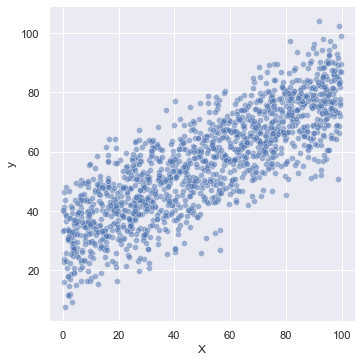

In [2]:
def generate_dataset(alpha: float, beta: float, sigma: float, n: int) -> pd.DataFrame:
    """Create synthetic regression data using linear model with Gaussian noise."""
    X = np.random.uniform(0, 100, n)
    epsilon = np.random.normal(0, 1, n)
    y = alpha + beta * X + sigma * epsilon
    dataset = pd.DataFrame({'y': y, 'X': X})
    return dataset.query('y >= 0')


dataset = generate_dataset(alpha=30, beta=0.5, sigma=10, n=24*60)
_ = sns.relplot(data=dataset, x='X', y='y', alpha=0.5)

## Time Varying Linear Model Coefficients

We want to be able to run this machine learning experiment indefinitely and have the linear model's 'slope' parameter, $\alpha$, vary with time. The changes need to be significant, so that we can introduce noticeable concept drift, but also deterministic. We have chosen a sinusoid model for this purpose, as given by,

$$
\alpha(d) = \kappa + A \times \sin \left( 2 \times \pi \times f \times \frac{d}{365} \right)
$$

Where $d \in [1, 365]$, is the day of the year. This is plotted below for 1 year.

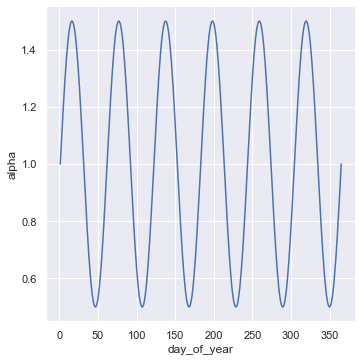

In [3]:
def alpha(day_of_year: int, f: float, kappa: float, A: float) -> float:
    """Return alpha on a given day of the year from a sinusoid model."""
    return kappa + A * np.sin(2 * np.pi * f * (day_of_year - 1) / 364)


alpha_plot_data = (
    pd
    .DataFrame({'day_of_year': np.arange(1, 366)})
    .assign(alpha=lambda d: alpha(d, f=6, kappa=1, A=0.5))
)

_ = sns.relplot(data=alpha_plot_data, x='day_of_year', y='alpha', kind='line')

## Upload Synthetic Dataset to Cloud Storage

Finally, we upload the Pandas DataFrame as a CSV, to AWS S3. The filename will based on the date it was generated.

In [4]:
def make_filename() -> str:
    """Get filename based on date it was generated."""
    date_string = str(date.today())
    return f'regression-dataset-{date_string}.csv'
    

dataset_filename = make_filename()
dataset.to_csv(dataset_filename, header=True, index=False)
    
s3_client = aws.client('s3')
s3_client.upload_file(dataset_filename,
    'bodywork-ml-ops-project',
    f'datasets/{dataset_filename}'
)
print(f'uploaded dataset {dataset_filename} to s3://bodywork-ml-ops-project/datasets')

uploaded dataset regression-dataset-2021-01-13.csv to s3://bodywork-ml-ops-project/datasets
